In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [3]:
disease_types = ['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy','Cherry_(including_sour)___healthy','Cherry_(including_sour)___Powdery_mildew','Grape___Black_rot','Grape___Esca_(Black_Measles)','Grape___healthy','Grape___Leaf_blight_(Isariopsis_Leaf_Spot)']
data_dir = 'D:/final_year_project/dataset/'
train_dir = os.path.join(data_dir)
#test_dir = os.path.join(data_dir, 'test')

In [4]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
5929,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/9ef...,9,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
5930,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/9f1...,9,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
5931,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/9f9...,9,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
5932,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/9f9...,9,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
5933,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/9fc...,9,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)


In [5]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Apple___healthy/0afaaf78-6ec5-49ee-a070-f62170...,3,Apple___healthy
1,Apple___healthy/05e20036-a134-46c0-a06f-3c5d47...,3,Apple___healthy
2,Cherry_(including_sour)___healthy/89bfbe68-6d5...,4,Cherry_(including_sour)___healthy
3,Grape___Black_rot/2d741855-2ea0-4103-8408-1292...,6,Grape___Black_rot
4,Grape___Black_rot/045e07eb-5005-4943-90f2-bd62...,6,Grape___Black_rot


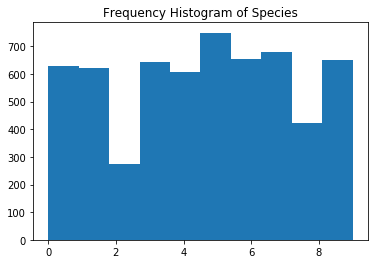

<Figure size 864x864 with 0 Axes>

In [6]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

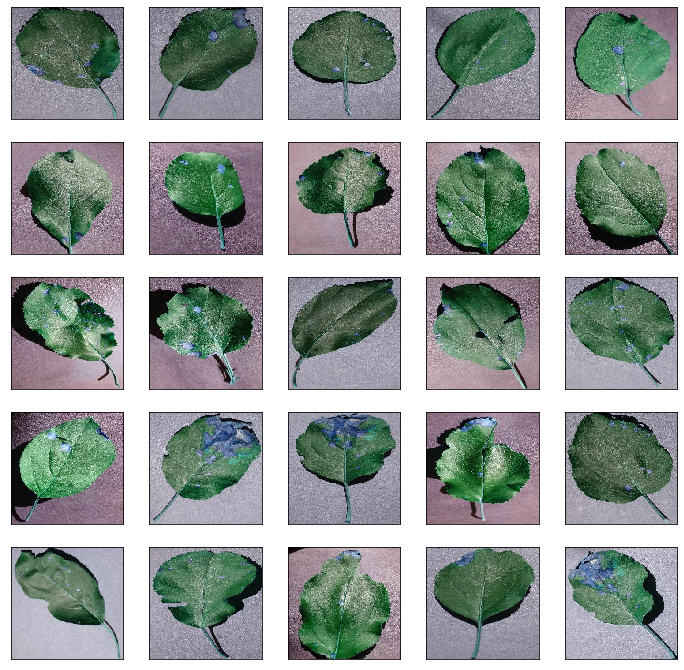

In [11]:
# Display images for different species
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Apple___Black_rot', 5, 5)

In [12]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [13]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

5934it [00:12, 488.18it/s]


Train Shape: (5934, 64, 64, 3)


In [14]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)


In [15]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

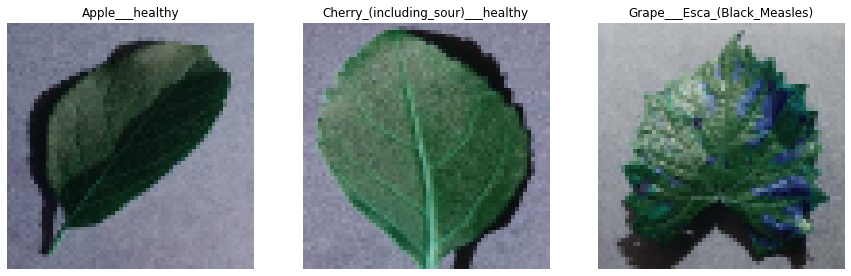

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [18]:
EPOCHS = 50
SIZE=64
N_ch=3

In [19]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(15,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model


In [20]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Instructions for updating:
Colocations handled automatically by placer.
30015488/30011760 [==============================] - 49s 2us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_____________________

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:958: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning



Epoch 00001: val_loss improved from inf to 2.34015, saving model to model.h5
Epoch 2/50
 - 632s - loss: 1.7034 - acc: 0.4873 - val_loss: 1.7553 - val_acc: 0.5897

Epoch 00002: val_loss improved from 2.34015 to 1.75527, saving model to model.h5
Epoch 3/50
 - 631s - loss: 0.9870 - acc: 0.6847 - val_loss: 1.3700 - val_acc: 0.6630

Epoch 00003: val_loss improved from 1.75527 to 1.37005, saving model to model.h5
Epoch 4/50
 - 633s - loss: 0.7023 - acc: 0.7752 - val_loss: 0.3994 - val_acc: 0.8703

Epoch 00004: val_loss improved from 1.37005 to 0.39938, saving model to model.h5
Epoch 5/50
 - 632s - loss: 0.5118 - acc: 0.8286 - val_loss: 0.2887 - val_acc: 0.8955

Epoch 00005: val_loss improved from 0.39938 to 0.28868, saving model to model.h5
Epoch 6/50
 - 639s - loss: 0.4025 - acc: 0.8678 - val_loss: 0.4844 - val_acc: 0.8543

Epoch 00006: val_loss did not improve
Epoch 7/50
 - 656s - loss: 0.3304 - acc: 0.8923 - val_loss: 0.2986 - val_acc: 0.8922

Epoch 00007: val_loss did not improve
Epoch 

In [21]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

1187/1187 [==============================] - 38s 32ms/step
Final Loss: 0.08865543041558681, Final Accuracy: 0.9688289806234204


Text(0.5, 144.41374999999996, 'Predicted')

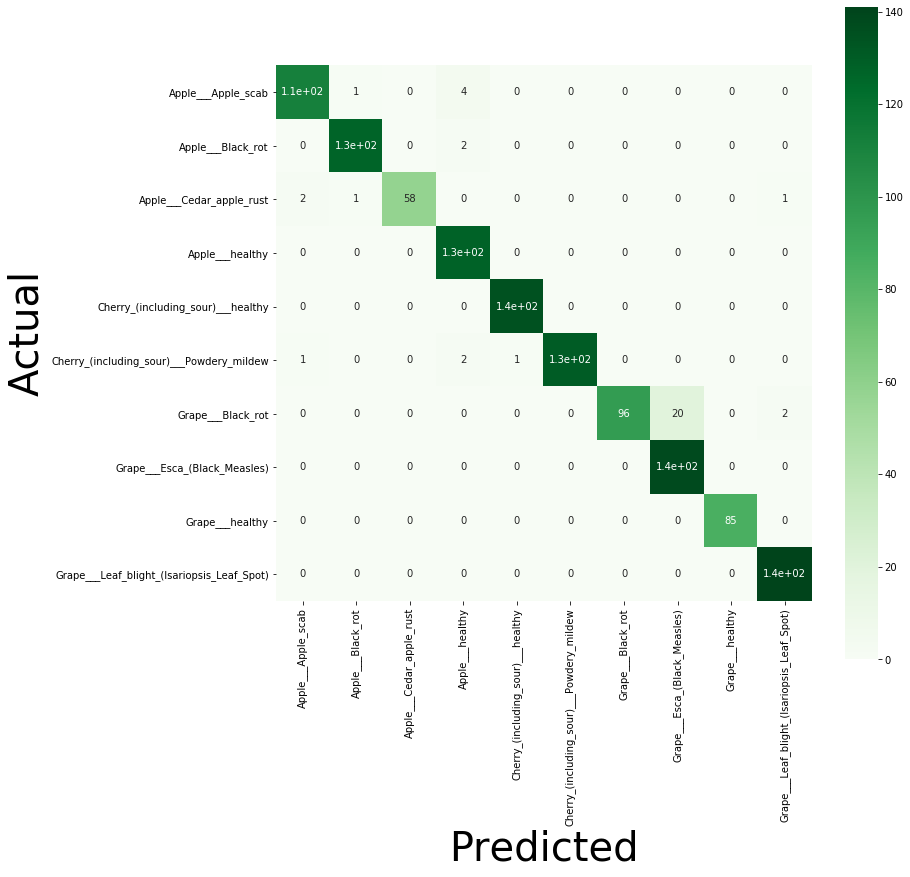

In [22]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [23]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

KeyError: 'accuracy'

In [24]:
model.metrics_names

['loss', 'acc']

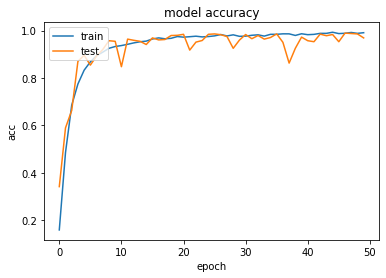

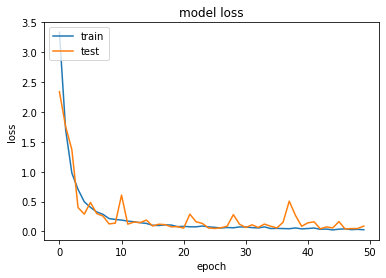

In [27]:
# accuracy plot 
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[1.6518241e-04 6.2586172e-03 6.3047721e-04 1.6221195e-01 2.7172558e-02
 3.6095520e-05 6.0100346e-03 2.4460278e-01 5.2270842e-01 4.6912152e-03
 5.9401537e-03 1.5634535e-03 9.4068171e-03 4.9239220e-03 3.6782757e-03]


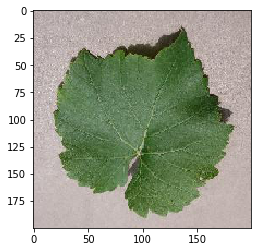

Prediction: Grape___healthy


In [31]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('D:/final_year_project/dataset/Grape___healthy/0eb2593a-5e67-4f13-91ea-105831323d54___Mt.N.V_HL 6117.JPG', grayscale=False, target_size=(64, 64))
show_img=image.load_img('D:/final_year_project/dataset/Grape___healthy/0eb2593a-5e67-4f13-91ea-105831323d54___Mt.N.V_HL 6117.JPG', grayscale=False, target_size=(200, 200))
disease_class = ['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy','Cherry_(including_sour)___healthy','Cherry_(including_sour)___Powdery_mildew','Grape___Black_rot','Grape___Esca_(Black_Measles)','Grape___healthy','Grape___Leaf_blight_(Isariopsis_Leaf_Spot)']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
#x = np.array(x, 'float32')
x /= 255

custom = model.predict(x)
print(custom[0])



#x = x.reshape([64, 64]);

#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])